# GPT Pipeline

The goal is to implement a pipeline where we take sentences from the commonsense norm bank, and through multiple steps turn it into first-order horn. Along the way we are interested to see what kind of sentences are not translate-able to horn.

Steps:
1. GPT-4 is asked to transform a Commonsense sentence to FOL, send result to (2)
2. Check if input is a WFF in FOL.
    - If no: Collect in WFF-FOL database, then break
    - If yes: step (3)
3. Check if input is CNF.
    - If no: Collect in CNF database, translate WFF FOL to CNF via translation script, then (4)
    - If yes: step (4)
4. Check if input is FOH.
    - If no: Collect in FOH database
    - If yes: Break

In [1]:
# Packages
# pip install --upgrade openai

import os
import openai 
import pandas as pd

from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

import prompts
from fol_parser import parse_text_FOL_to_tree

/opt/anaconda3/envs/logicllama/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPT translation

### Horn Convertion testing

In [13]:
test = 'evaluation(GOOD) | ~Friends(v0, v1) | ~ExpectRevealEverything(v0, v1)'


antecedent = []
consequence = []

test_splt = test.split('|')
for i in test_splt:
    if i.strip()[0] != '~':
        consequence.append(i.strip())
    else:
        i = i.replace('~', '¬')
        antecedent.append(i.strip())

if len(consequence) > 1:
    print('Not horn clause')
else:
    antecedent_joined = (' ∨ ').join(antecedent)
    joined = (' ∨ ').join([antecedent_joined, consequence[0]])
    print(joined)
        


¬Friends(v0, v1) ∨ ¬ExpectRevealEverything(v0, v1) ∨ evaluation(GOOD)


In [ ]:
# ∀x∀y(Buddy(x,y) ∧ GoesCampingWith(x,y) ∧ ∀z    (Has(x,z)) → evaluation(GOOD))
# til
# ∀x∀y∀z(Buddy(x,y) ∧ GoesCampingWith(x,y) ∧ Has(x,z) → evaluation(GOOD))

In [5]:
from juliacall import Main as jl
jl.include("/Users/emmabjorkas/Documents/Informasjonsvitenskap/Master/gpt_pipeline/First-order-Logic-resolution-master/hw2.jl")

resolve (generic function with 1 method)

In [6]:
def replace_op(formula):
    """
    Replaces the operators in a formula to woek with Julia code.

    Args:
        formula (str): The formula to be edited

    Returns:
        str: The edited formula
    """
    formula = formula.replace('∨', '|')
    formula = formula.replace('∧', '&')
    formula = formula.replace('→', '==>')
    formula = formula.replace('↔', '<=>')
    formula = formula.replace('¬', '~')
    return formula


def fol_to_cnf_converter(lst):
    """Converts a list of FOL formulas to CNF using Julia code.

    Args:
        lst (list): The list of FOL formulas to be converted

    Returns:
        lst: The list of converted formulas.
    """
    clauses = jl.map(jl.skolemize, jl.map(jl.toCNF, jl.map(jl.toClause, jl.map(jl.lexer, lst))))
    translated_formulas = []
    for i in clauses:
        formatted = jl.printClause(i)
        translated_formulas.append(formatted)
    return translated_formulas


def fol_to_cnf(lst, col_name="", prompt_iteration="", adjustment_iteration=""):
    """Creates a data frame of the CNF translations and evaluations.

    Args:
        df (DataFrame): The dataframe to iterate through
        col_name (str): Name of the column to save the translations and evaluations to
        prompt_iteration (str): Name of the prompt iteration
        adjustment_iteration (str): Name of the prompt iteration
    """

    cnf_formulas = []
    cnf_evals = []

    for index in range(len(lst)):
        try:
            converted = fol_to_cnf_converter([replace_op(lst[index])])
            cnf_formulas.append(converted[0])
            cnf_evals.append(1)
            print(f'FOL: {lst[index]}\nCNF: {converted[0]}\n')
        except Exception as e:
            cnf_formulas.append('ERROR')
            cnf_evals.append(-1)
            print(f'FOL: {lst[index]}\Error: {e}\n')

In [7]:
lst = ["∀x0∀y0∀y1(Girl(x0) ∧ Girl(y0) ∧ Friends(x0, y0) ∧ (Boy(y1) ∧ Enemies(x0, y1)) → evaluation(GOOD))"]

In [8]:
fol_to_cnf(lst)

FOL: ∀x0∀y0∀y1(Girl(x0) ∧ Girl(y0) ∧ Friends(x0, y0) ∧ (Boy(y1) ∧ Enemies(x0, y1)) → evaluation(GOOD))
CNF: evaluation(GOOD) | ~Girl(v0) | ~Girl(v1) | ~Friends(v0, v1) | ~Boy(v2) | ~Enemies(v0, v2)



FOL: ¬∃x∀y1(Buddy(x,y1) ∧ GoesCampingWith(x,y1) → evaluation(GOOD))

CNF: evaluation(GOOD) | ~Buddy(v19, v18) | ~GoesCampingWith(v19, v18)

In [13]:
from nltk.sem import skolemize, Expression

test = 'exist x. (Buddy(x) and (all y. (GoesCampingWith(x,y))) implies evaluation(GOOD))'
skol = (skolemize(Expression.fromstring(test)))
print(skol)

(-Buddy(z2) | -GoesCampingWith(z2,z1) | evaluation(GOOD))


'⊕', '∨', '∧', '→', '↔', '∀', '∃', '¬', '(', ')', ','



In [21]:
def isolate_quantifier_range(f):
    quantifiers = []
    for i in range(len(f)):
        if f[i] == '∀' or f[i] == '∃':
            sub_str = f[i+2:]
            q_range = '('
            p = 1
            p_i = sub_str.find('(')
            q_range += sub_str[:p_i]
            sub_str = sub_str[p_i+1:]
            for j in range(len(sub_str)+1):
                if p == 0:
                    q_range += sub_str[:j]
                    print(f[i:i+2],q_range)
                    quantifiers.append([f[i:i+2], q_range])
                    break
                if sub_str[j] == '(':
                    p += 1
                elif sub_str[j] == ')':
                    p -=1 
    return quantifiers

In [22]:
f = '∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))'
quantifiers = (isolate_quantifier_range(f))

∀x (∀z∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
∀z (∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
∀y (Buddy(x,y))
∃y (GoesCampingWith(x,y))


In [38]:
quantifiers

[['∀x', '(∀z∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))'],
 ['∀z', '(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))'],
 ['∀y', '(Buddy(x,y))'],
 ['∃y', '(GoesCampingWith(x,y))']]

In [23]:
n_quantifiers = []
for i in quantifiers:
    n_quantifiers.append(i[0]+i[1])
print(n_quantifiers)

['∀x(∀z∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))', '∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))', '∀y(Buddy(x,y))', '∃y(GoesCampingWith(x,y))']


In [66]:
def test(f, q):
    quant_dict = {}
    sorted_q = sorted(q, key=len)
    for i in range(len(sorted_q)):
        quant_dict[i] = sorted_q[i]
    quant_dict[len(sorted_q)] = f
    return quant_dict
    #print(sorted_q)

In [67]:
f = '∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))'
q_dict = test(f, n_quantifiers)

In [68]:
new_dict = q_dict
for key, value in q_dict.items():
    print("current value:", value)
    for rep_key, rep_value in q_dict.items():
        if rep_value == value:
            continue
        elif rep_value in value:
            print("replace value:", rep_value)
            new = new_dict[key].replace(rep_value, ("*"+str(rep_key)+"*"))
            print(new)
            new_dict[key] = new
    print()
print(new_dict)

current value: ∀y(Buddy(x,y))

current value: ∃y(GoesCampingWith(x,y))

current value: ∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∀y(Buddy(x,y))
∀z(*0* ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∃y(GoesCampingWith(x,y))
∀z(*0* ∧ *1* → evaluation(GOOD))

current value: ∀x(∀z∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∀y(Buddy(x,y))
∀x(∀z*0* ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∃y(GoesCampingWith(x,y))
∀x(∀z*0* ∧ *1* → evaluation(GOOD))

current value: ∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∀y(Buddy(x,y))
∀x∀z(*0* ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
replace value: ∃y(GoesCampingWith(x,y))
∀x∀z(*0* ∧ *1* → evaluation(GOOD))

{0: '∀y(Buddy(x,y))', 1: '∃y(GoesCampingWith(x,y))', 2: '∀z(*0* ∧ *1* → evaluation(GOOD))', 3: '∀x(∀z*0* ∧ *1* → evaluation(GOOD))', 4: '∀x∀z(*0* ∧ *1* → evaluation(GOOD))'}


In [69]:
for key, value in new_dict.items():
    uniqe_vars = value.replace
    print(key, value)

0 ∀y(Buddy(x,y))
1 ∃y(GoesCampingWith(x,y))
2 ∀z(*0* ∧ *1* → evaluation(GOOD))
3 ∀x(∀z*0* ∧ *1* → evaluation(GOOD))
4 ∀x∀z(*0* ∧ *1* → evaluation(GOOD))


In [9]:
import re

def parse_nested(text, left=r'[(]', right=r'[)]', sep=r','):
    """ Based on https://stackoverflow.com/a/17141899/190597 (falsetru) """
    pat = r'({}|{}|{})'.format(left, right, sep)
    tokens = re.split(pat, text)    
    stack = [[]]
    for x in tokens:
        if not x or re.match(sep, x): continue
        if re.match(left, x):
            stack[-1].append([])
            stack.append(stack[-1][-1])
        elif re.match(right, x):
            stack.pop()
            if not stack:
                raise ValueError('error: opening bracket is missing')
        else:
            stack[-1].append(x)
    if len(stack) > 1:
        print(stack)
        raise ValueError('error: closing bracket is missing')
    return stack.pop()

# [[['wordOneWord2'], 'OtherWord', ['FinalWord']]]

In [10]:
f = '∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))'
print(f)
print()
list_rep = parse_nested(f)

∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))



In [12]:
def innermost(data):
    for item in data:
        if isinstance(item, list):
            return innermost(item)
        else:
            continue
    return data

print(list_rep)
innermost(list_rep)

['∀x∀z', ['∀y', ['Buddy', ['x', 'y']], ' ∧ ∃y', ['GoesCampingWith', ['x', 'y']], ' → evaluation', ['GOOD']]]


['x', 'y']

In [119]:
import re

def eliminate_negated_quantifiers(f, num_neg=0):
    for i in range(len(f)-1):
        try:
            if f[i] == '¬' and f[i+1] == '¬':
                f = f[:i] + f[i+2:]
            elif f[i] == '¬' and f[i+1] == '∀':
                f = f[:i] + '∃' + f[i+2] + '¬' + f[i+3:]
            elif f[i] == '¬' and f[i+1] == '∃':
                f = f[:i] + '∀' + f[i+2] + '¬' + f[i+3:]
        except Exception as e:
            break
    while num_neg > 1:
        f = eliminate_negated_quantifiers(f, num_neg-1)
        num_neg -= 1
    return f


In [125]:
f = '∃x(Buddy(x) ∧ ¬∀y(GoesCampingWith(x,y)) → evaluation(GOOD))'
print(eliminate_negated_quantifiers(f, f.count('¬')+1))

∃x(Buddy(x) ∧ ∃y¬(GoesCampingWith(x,y)) → evaluation(GOOD))


In [346]:
from nltk.tree import *

f = '(∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD)))'

tree = Tree.fromlist(parse_nested(f))

AttributeError: 'str' object has no attribute 'tree'

In [345]:
tree

AttributeError: 'str' object has no attribute 'pretty_print'

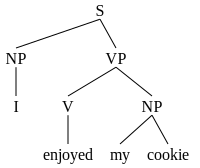

In [340]:
test_tree = Tree.fromstring('(S (NP I) (VP (V enjoyed) (NP my cookie)))')
test_tree

## KRISELØSNING

Sjekker om det blir brukt like variabler ulike steder i formelen, i så fall kan den forkastes.

In [27]:
def repeat_var(f):
    vars = []
    eval = False
    for i in range(len(f)):
        if f[i] == '∃' or f[i] == '∀':
            if f[i+1] not in vars:
                vars.append(f[i+1])
            else:
                print(f"Dupe var: {f[i+1]}")
                eval = True
    return eval

print(f)
print(repeat_var(f))

∀x∀z(∀y(Buddy(x,y)) ∧ ∃y(GoesCampingWith(x,y)) → evaluation(GOOD))
Dupe var: y
True


In [37]:
def push_quantifiers(f):
    if repeat_var(f) == True:
        print("Formula contains repeated variables and is discarded.")
        return None
    else:
        quants = ""
        new_f = f
        for i in range(len(f)-2):
            if f[i] == "∀" or f[i] == "∃":
                quants += f[i:i+2]
                new_f = new_f.replace(f[i:i+2], "")
        new_f = quants+new_f
    return new_f

f = "∀x∀z(∀y(Buddy(x,y)) ∧ ∃w(GoesCampingWith(x,w)) → evaluation(GOOD))"
push_quantifiers(f)

'∀x∀z∀y∃w((Buddy(x,y)) ∧ (GoesCampingWith(x,w)) → evaluation(GOOD))'

In [15]:
import re
def rename_quantifier_variables(F, current_variable="init", current_quantifiers = {"init":0}, new = ""):
    """
    Renames the duplicate quantifier variables in a given formula.

    Parameters:
    - F (str): The formula to rename the quantifier variables in.
    - current_variable (str): The current variable being processed. Default is "init".

    Returns:
    - str: The formula with renamed quantifier variables.
    """
    form = F+"*"
    num_parent = 1
    i=0
    while form[i] != "*":
        if form[i]=='∀' or form[i] == "∃":
            new = new+form[i]
            var = form[i+1]
            if var in current_quantifiers:
                current_quantifiers[var] = current_quantifiers[var] + 1
                return rename_quantifier_variables(form[i+1:], var, current_quantifiers, new)
            else:
                current_quantifiers[var] = 0
                return rename_quantifier_variables(form[i+1:], var, current_quantifiers, new)
        elif form[i] in current_quantifiers:
            pre = form[i-1]
            post = form[i+1]
            if re.search("[a-zA-Z]", pre) == None and re.search("[a-zA-Z]", post) == None:
                new = new + form[i]+str(current_quantifiers[form[i]]) 
            else:
                new = new + form[i]
        elif form[i] == '(':
            new = new + form[i]
            num_parent += 1
        elif form[i] == ')':
            new = new + form[i]
            num_parent -= 1
        else:
            new = new + form[i]
        if num_parent == 0:
            current_quantifiers[current_variable] -= 1
        i+=1
    return(new)

In [16]:
rename_quantifier_variables("∀x∀y(G(x) ∧ G(y) ∧ F (x, y) ∧ ∀y(B(y) ∧ E(x, y)) → evaluation(GOOD))")

'∀x0∀y0(G(x0) ∧ G(y0) ∧ F (x0, y0) ∧ ∀y1(B(y1) ∧ E(x0, y1)) → evaluation(GOOD))'

In [7]:
def push_quantifiers(f):
    """
    Removes quantifiers (∀, ∃) from the input string and pushes them to the beginning of the string.

    Args:
        f (str): The input string containing quantifiers.

    Returns:
        str: The modified string with quantifiers pushed to the beginning.
    """
    quants = ""
    new_f = f
    for i in range(len(f)-2):
        if f[i] == "∀" or f[i] == "∃":
            try:
                test = int(f[i+2])
                quants += f[i:i+3]
                new_f = new_f.replace(f[i:i+3], "")
            except:
                quants += f[i:i+2]
                new_f = new_f.replace(f[i:i+2], "")
    new_f = quants+new_f
    return new_f

In [17]:
push_quantifiers('∀x0∀y0(G(x0) ∧ G(y0) ∧ F(x0, y0) ∧ ∀y1(B(y1) ∧ E(x0, y1)) → evaluation(GOOD))')

'∀x0∀y0∀y1(G(x0) ∧ G(y0) ∧ F(x0, y0) ∧ (B(y1) ∧ E(x0, y1)) → evaluation(GOOD))'

In [12]:
from random import randint
num = f"{str(randint(0,9))}" +f"{str(randint(0,9))}"+f"{str(randint(0,9))}"
print(num)

065
